In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
RANDOM_SEED=25
df = pd.read_csv('data/filmdeathcounts.csv', sep=',')

# Homework 3

In [16]:
def categorize_number_of_deaths(num_of_deaths):
    if num_of_deaths < 10:
        return '9-'
    elif num_of_deaths < 100:
        return '10+'
    elif num_of_deaths < 200:
        return '100+'
    else:
        return '200+'

def categorize_rating(rating):
    if rating < 5.0:
        return '5.0-'
    elif rating < 7.0:
        return '5.0+'
    elif rating < 8.0:
        return '7.0+'
    else:
        return '8.0+'
    
def categorize_year(year):
    if year < 1990:
        return '1989-'
    elif year < 2000:
        return '1990+'
    elif year < 2005:
        return '2000+'
    else:
        return '2005+'

def make_quetelet(probabilites_df):
    res = probabilites_df.copy()
    res.drop(index='Total', columns='Total', inplace=True)
    for col in res:
        for row in res[col].index:
            res[col][row] = (probabilites_df[col][row] / probabilites_df['Total'][row] - probabilites_df[col]['Total']) / \
                             probabilites_df[col]['Total']
    return res

bodies = df['Body_Count'].apply(categorize_number_of_deaths)
imdb_rating = df['IMDB_Rating'].apply(categorize_rating)
year = df['Year'].apply(categorize_year)

contingency_table_imdb_bodies = pd.crosstab(bodies, imdb_rating, margins=True, margins_name='Total', normalize='all')
contingency_table_year_bodies = pd.crosstab(bodies, year, margins=True, margins_name='Total', normalize='all')


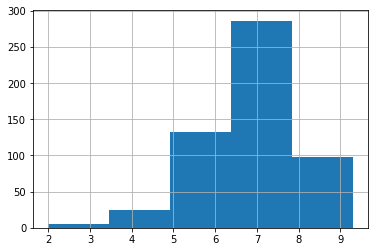

In [13]:
df['IMDB_Rating'].hist(bins=5)

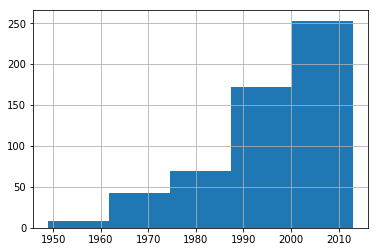

In [27]:
df['Year'].hist(bins=5)

In [10]:
contingency_table_imdb_bodies * 100

IMDB_Rating,5.0+,5.0-,7.0+,8.0+,Total
Body_Count,,,,,
10+,31.743119,2.935780,18.165138,8.623853,61.467890
100+,5.504587,1.284404,5.871560,2.568807,15.229358
200+,1.834862,0.183486,4.220183,0.733945,6.972477
9-,7.522936,0.917431,5.137615,2.752294,16.330275
Total,46.605505,5.321101,33.394495,14.678899,100.000000


In [11]:
contingency_table_year_bodies * 100

Year,1989-,1990+,2000+,2005+,Total
Body_Count,,,,,
10+,13.944954,19.082569,11.192661,17.247706,61.467890
100+,6.605505,2.201835,3.119266,3.302752,15.229358
200+,1.284404,1.100917,1.834862,2.752294,6.972477
9-,3.302752,3.119266,5.321101,4.587156,16.330275
Total,25.137615,25.504587,21.467890,27.889908,100.000000


In [17]:
make_quetelet(contingency_table_imdb_bodies) * 100

IMDB_Rating,5.0+,5.0-,7.0+,8.0+
Body_Count,,,,
10+,10.806205,-10.241894,-11.505659,-4.421642
100+,-22.445688,58.496053,15.450814,14.909639
200+,-43.535019,-50.544465,81.246385,-28.289474
9-,-1.154561,5.579233,-5.790838,14.817416


1. Films that have from 100 to 199 bodies have odds to have rating lower than 5.0 ~58% more than average
2. Films that have 200 or more bodies have odds to have rating higher than 7.0 ~81% more than average

In [18]:
make_quetelet(contingency_table_year_bodies) * 100

Year,1989-,1990+,2000+,2005+
Body_Count,,,,
10+,-9.750517,21.722324,-15.180508,0.608798
100+,72.544191,-43.312820,-4.592730,-22.241598
200+,-26.719170,-38.091632,22.582096,41.533934
9-,-19.544001,-25.107105,51.781427,0.717031


1. Films that have from 100 to 199 bodies are most probably made before 1990 (probability is ~73% more than average)
2. Films that have 200 or more bodies are most probably made after 2005 (probability is ~41% more than average)